# 2. Обучение

In [1]:
# Импорт библиотек
import pandas as pd

import pickle

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

import shap

In [2]:
# ##################################################################################################################################################################
#                      !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ##################################################################################################################################################################
#
# At the moment, only a part of the hybrid metal(III) halides dataset is presented, it will be fully available after the article is rejected.
#
# Your results from this notebook will be different and not very informative.
#
# Therefore, where important information is displayed, copies of the outputs obtained on all data are given.
#
# ##################################################################################################################################################################
#                      !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ##################################################################################################################################################################

In [3]:
# Загрузка датасета:
df = pd.read_csv('Data_for_bg_prediction.csv', sep='\t', index_col=[0])
df.head(10)

,REFCODE,Band gap,M,X,Bi,Sb,I,Br,Cl,Temperature,...,t2-d3,t2-d4,d1-d2,d1-d3,d1-d4,d2-d3,d2-d4,d3-d4,delta d,sigma^2
0,AGODEI,2.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,150.0,...,90.072,94.778,86.451,80.071,91.585,91.585,177.438,86.451,0.001670,26.536168
1,AGODIM,2.07,0.0,0.0,1.0,0.0,1.0,0.0,0.0,150.0,...,89.135,93.715,88.559,87.220,87.640,89.067,175.548,88.436,0.002430,4.061154
2,AGODOS,1.97,0.0,0.0,1.0,0.0,1.0,0.0,0.0,120.0,...,90.864,95.538,86.936,80.996,91.075,91.075,177.386,86.936,0.000974,22.655187
3,AGODOS01,1.94,0.0,0.0,1.0,0.0,1.0,0.0,0.0,297.0,...,90.625,94.803,86.278,81.729,91.836,91.836,177.509,86.278,0.001250,19.705712
4,AYENEZ,2.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,292.0,...,92.116,93.791,88.483,84.036,88.227,85.743,173.823,88.717,0.002171,11.252038
5,AYENEZ01,2.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,150.0,...,93.164,93.804,89.474,83.165,87.247,85.220,174.042,89.449,0.002060,13.529862
6,AYENOJ,1.95,0.0,0.0,1.0,0.0,1.0,0.0,0.0,292.0,...,91.911,94.924,87.010,84.379,89.589,88.861,175.368,87.675,0.002088,10.257849
7,AYENOJ01,1.95,0.0,0.0,1.0,0.0,1.0,0.0,0.0,150.0,...,92.448,94.979,87.837,83.753,88.837,88.501,175.644,88.342,0.001992,10.992420
8,AYEPAX,1.92,0.0,0.0,1.0,0.0,1.0,0.0,0.0,286.0,...,88.221,93.360,86.534,84.468,91.715,90.523,176.133,85.874,0.001954,14.016866
9,AYEPAX01,1.92,0.0,0.0,1.0,0.0,1.0,0.0,0.0,150.0,...,88.087,93.227,87.178,84.231,91.451,89.855,176.199,86.479,0.001843,14.269430


In [4]:
# Избавляемя от хлоридных комплексов
df.drop(index=df[df['Cl']>0].index, inplace=True)

In [5]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 84
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   REFCODE                       79 non-null     object 
 1   Band gap                      79 non-null     float64
 2   M                             79 non-null     float64
 3   X                             79 non-null     float64
 4   Bi                            79 non-null     float64
 5   Sb                            79 non-null     float64
 6   I                             79 non-null     float64
 7   Br                            79 non-null     float64
 8   Cl                            79 non-null     float64
 9   Temperature                   79 non-null     float64
 10  min Hal...Hal                 79 non-null     float64
 11  aver Hal...Hal                79 non-null     float64
 12  Number of Hal...Hal contacts  79 non-null     float64
 13  N/aver-

null_counts is deprecated. Use show_counts instead


In [6]:
# Вспомогательные функции для выбора фичей:
from my_scripts import get_descriptors_by_ent #на самом деле далее ей не пользовался, удобней сразу вбивать фичи

In [7]:
# Что все выводилось в этом блокноте
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1. Предварительное обучение на всех геометрических (21) дескрипторах

In [8]:
# Возможные пространства
descriptors_sets = [['M', 'X', 'Temperature', 'min Hal...Hal', 'Hal-t1', 'Hal-t2', 'Hal-d1', 'Hal-d2', 'Hal-d3', 'Hal-d4','t1-t2', 't1-d1',
                       't1-d2', 't1-d3', 't1-d4', 't2-d1', 't2-d2', 't2-d3', 't2-d4', 'd1-d2', 'd1-d3', 'd1-d4', 'd2-d3', 'd2-d4', 'd3-d4'],
                ['M', 'X', 'Temperature', 'aver Hal...Hal', 'Hal-t1', 'Hal-t2', 'Hal-d1', 'Hal-d2', 'Hal-d3', 'Hal-d4','t1-t2', 't1-d1',
                       't1-d2', 't1-d3', 't1-d4', 't2-d1', 't2-d2', 't2-d3', 't2-d4', 'd1-d2', 'd1-d3', 'd1-d4', 'd2-d3', 'd2-d4', 'd3-d4'],
                ['M', 'X', 'Temperature', 'aver Hal...Hal', 'Number of Hal...Hal contacts', 'Hal-t1', 'Hal-t2', 'Hal-d1', 'Hal-d2', 'Hal-d3', 'Hal-d4','t1-t2', 't1-d1',
                       't1-d2', 't1-d3', 't1-d4', 't2-d1', 't2-d2', 't2-d3', 't2-d4', 'd1-d2', 'd1-d3', 'd1-d4', 'd2-d3', 'd2-d4', 'd3-d4'],
                ['M', 'X', 'Temperature', 'N/aver-d', 'Hal-t1', 'Hal-t2', 'Hal-d1', 'Hal-d2', 'Hal-d3', 'Hal-d4','t1-t2', 't1-d1',
                       't1-d2', 't1-d3', 't1-d4', 't2-d1', 't2-d2', 't2-d3', 't2-d4', 'd1-d2', 'd1-d3', 'd1-d4', 'd2-d3', 'd2-d4', 'd3-d4'],
                ['M', 'X', 'Temperature', 'min Hal...Hal', 'Number of Hal...Hal contacts', 'Hal-t1', 'Hal-t2', 'Hal-d1', 'Hal-d2', 'Hal-d3', 'Hal-d4','t1-t2', 't1-d1',
                       't1-d2', 't1-d3', 't1-d4', 't2-d1', 't2-d2', 't2-d3', 't2-d4', 'd1-d2', 'd1-d3', 'd1-d4', 'd2-d3', 'd2-d4', 'd3-d4'],
               ]

Подготовка данных

In [9]:
from my_scripts import train_test_split_and_normolize #Функция для разбиения на трейн и тест и нормализации

In [10]:
x_train, x_test, y_train, y_test, scaler = train_test_split_and_normolize(df, drop=True, train_size=0.85, random_state=156, shuffle=True, stratify=df[df['Hal-t1'].notna()]['X'])
sum(x_train['I'] == 1), sum(x_test['I'] == 1), sum(x_train['Br'] == 1), sum(x_test['Br'] == 1), sum(x_train['Br'] == 0.5), sum(x_test['Br'] == 0.5)

In train set 64 In test set 12


(48, 9, 13, 3, 3, 0)

In [11]:
from my_scripts import pipline_true, find_biggest_error # Функкции для всего цикла обучения и нахождения объектов с наибольшей ошибкой
from my_scripts import score_plots, r2_plot # Для отрисовки графиков

In [12]:
# Поиск гиперпараметров

# a = [0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
# gpr1 = {'GPR_rbf ' + str(x): GaussianProcessRegressor(kernel=RBF(), alpha=x, n_restarts_optimizer=10, normalize_y=True) for x in a}
#          # 'GPR_mat': GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=0.2, n_restarts_optimizer=10, normalize_y=True),
# res_gpr2 = pipline_true(x_train, x_test, y_train, y_test, descriptors_sets[3], models=gpr1, metrics=metrics)
# res_gpr2[0]

In [13]:
metrics = {'MAE': mean_absolute_error, 'MSE': mean_squared_error, 'RMSE': mean_squared_error, 'R2': r2_score}
models1 = {'Linear': LinearRegression(),
          'SVR_lin': SVR(kernel="linear", C=100, gamma="auto"),
          'SVR_poly': SVR(kernel="poly", C=100, gamma="auto"),
          'SVR_rbf': SVR(kernel="rbf", C=100, gamma="auto"),
          'GPR_rbf': GaussianProcessRegressor(kernel=RBF(), alpha=0.2, n_restarts_optimizer=10, normalize_y=True),
          'GPR_mat': GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=0.2, n_restarts_optimizer=10, normalize_y=True),
          'GPR_rt': GaussianProcessRegressor(kernel=RationalQuadratic(), normalize_y=True, n_restarts_optimizer=10, alpha=0.2),
          'RF': RandomForestRegressor(n_estimators=1000, max_depth=1, n_jobs=-1),
          'XGB': xgb.XGBRegressor(max_depth=1),
          }

In [14]:
res = []
for descriptors_set in descriptors_sets:
    res.append(pipline_true(x_train, x_test, y_train, y_test, descriptors_set, models=models1, metrics=metrics))

Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale t


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bou


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper 


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bou


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bou


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


In [15]:
# Результаты кросс-валидации

In [16]:
for r in res:
    r[0]

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.062612  0.001796  0.080794  0.001350  0.072809  0.001512   
MAE on validate   0.148254  0.184538  0.126066  0.118601  0.102204  0.094798   
MSE on train      0.007367  0.000427  0.009399  0.000357  0.008575  0.000386   
MSE on validate   0.055502  0.138780  0.029739  0.055039  0.019292  0.034409   
RMSE on train     0.085793  0.002635  0.096930  0.001914  0.092577  0.002214   
RMSE on validate  0.148254  0.184538  0.126066  0.118601  0.102204  0.094798   
R2 on train       0.899876  0.005911  0.872264  0.004946  0.883446  0.005646   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.077226  0.001231  0.067630  0.001424  0.065843  0.001450   
MAE on validate   0.121348  0.109268  0.091060  0.089170  0.091117  0.089911   
MSE on train      0.007960  0.000297  0.009103  0.000401  0.008729  0.000390   
MSE on validate   0.026478  0.046414  0.016119  0.035437  0.016260  0.035812   
RMSE on train     0.089201  0.001726  0.095385  0.002234  0.093405  0.002227   
RMSE on validate  0.121348  0.109268  0.091060  0.089170  0.091117  0.089911   
R2 on train       0.891817  0.004237  0.876289  0.005474  0.881373  0.005256   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.067630  0.001424  0.094692  0.001368  0.025848  0.001144  
MAE on validate   0.091060  0.089170  0.104862  0.103213  0.098971  0.093391  
MSE on train      0.009103  0.000401  0.017032  0.000412  0.001290  0.000109  
MSE on validate   0.016119  0.035437  0.021482  0.050994  0.018381  0.035806  
RMSE on train     0.095385  0.002234  0.130498  0.001599  0.035876  0.001672  
RMSE on validate  0.091060  0.089170  0.104862  0.103213  0.098971  0.093391  
R2 on train       0.876289  0.005474  0.768514  0.006197  0.982466  0.001564

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.065814  0.002010  0.081032  0.001468  0.071388  0.001313   
MAE on validate   0.155607  0.192495  0.120008  0.107882  0.102547  0.096823   
MSE on train      0.007908  0.000466  0.009622  0.000375  0.008334  0.000351   
MSE on validate   0.060689  0.167297  0.025858  0.047074  0.019744  0.034935   
RMSE on train     0.088882  0.002773  0.098072  0.001995  0.091266  0.002054   
RMSE on validate  0.155607  0.192495  0.120008  0.107882  0.102547  0.096823   
R2 on train       0.892531  0.006466  0.869237  0.005087  0.886729  0.005207   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.077904  0.001486  0.068402  0.001451  0.066591  0.001458   
MAE on validate   0.123532  0.110041  0.091626  0.089236  0.091661  0.090069   
MSE on train      0.008110  0.000339  0.009296  0.000404  0.008914  0.000394   
MSE on validate   0.027180  0.046956  0.016234  0.035725  0.016387  0.036131   
RMSE on train     0.090033  0.001956  0.096391  0.002227  0.094387  0.002224   
RMSE on validate  0.123532  0.110041  0.091626  0.089236  0.091661  0.090069   
R2 on train       0.889784  0.004723  0.873667  0.005518  0.878866  0.005306   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.068402  0.001451  0.094784  0.001484  0.025366  0.001146  
MAE on validate   0.091626  0.089236  0.104494  0.104092  0.095173  0.092160  
MSE on train      0.009296  0.000404  0.017060  0.000387  0.001249  0.000108  
MSE on validate   0.016234  0.035725  0.021585  0.051529  0.017419  0.034242  
RMSE on train     0.096391  0.002227  0.130607  0.001496  0.035303  0.001682  
RMSE on validate  0.091626  0.089236  0.104494  0.104092  0.095173  0.092160  
R2 on train       0.873667  0.005518  0.768122  0.006127  0.983017  0.001588

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.066041  0.002004  0.081653  0.001721  0.071397  0.001727   
MAE on validate   0.159381  0.195262  0.132577  0.129457  0.103183  0.099667   
MSE on train      0.007837  0.000465  0.009648  0.000352  0.008313  0.000414   
MSE on validate   0.062934  0.169825  0.034074  0.069265  0.020425  0.036661   
RMSE on train     0.088484  0.002776  0.098207  0.001863  0.091146  0.002393   
RMSE on validate  0.159381  0.195262  0.132577  0.129457  0.103183  0.099667   
R2 on train       0.893490  0.006436  0.868861  0.005355  0.886997  0.006198   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.078979  0.001920  0.066730  0.001347  0.064222  0.001340   
MAE on validate   0.131108  0.124742  0.091804  0.091135  0.090920  0.091947   
MSE on train      0.008020  0.000347  0.008904  0.000381  0.008416  0.000362   
MSE on validate   0.032507  0.066002  0.016604  0.035870  0.016589  0.035918   
RMSE on train     0.089531  0.001989  0.094336  0.002126  0.091717  0.002082   
RMSE on validate  0.131108  0.124742  0.091804  0.091135  0.090920  0.091947   
R2 on train       0.891000  0.004971  0.879000  0.005180  0.885626  0.004852   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.066730  0.001347  0.094736  0.001410  0.025367  0.001144  
MAE on validate   0.091804  0.091135  0.103665  0.104093  0.095209  0.092268  
MSE on train      0.008904  0.000381  0.017067  0.000449  0.001249  0.000109  
MSE on validate   0.016604  0.035870  0.021412  0.051302  0.017445  0.034335  
RMSE on train     0.094336  0.002126  0.130630  0.001742  0.035302  0.001684  
RMSE on validate  0.091804  0.091135  0.103665  0.104093  0.095209  0.092268  
R2 on train       0.879000  0.005180  0.768046  0.006306  0.983018  0.001591

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.072510  0.002540  0.082252  0.001435  0.074297  0.001641   
MAE on validate   0.167139  0.201941  0.122543  0.114648  0.103847  0.094764   
MSE on train      0.008652  0.000520  0.010009  0.000395  0.008491  0.000395   
MSE on validate   0.068078  0.210615  0.027956  0.057999  0.019624  0.035827   
RMSE on train     0.092970  0.002960  0.100023  0.002085  0.092120  0.002270   
RMSE on validate  0.167139  0.201941  0.122543  0.114648  0.103847  0.094764   
R2 on train       0.882417  0.007132  0.863972  0.005564  0.884584  0.005835   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.076997  0.001278  0.068814  0.001445  0.065712  0.001402   
MAE on validate   0.125569  0.119078  0.094090  0.091472  0.092426  0.092147   
MSE on train      0.007870  0.000250  0.009232  0.000392  0.008652  0.000370   
MSE on validate   0.029726  0.059207  0.017089  0.036533  0.016901  0.036413   
RMSE on train     0.088703  0.001438  0.096058  0.002147  0.092991  0.002096   
RMSE on validate  0.125569  0.119078  0.094090  0.091472  0.092426  0.092147   
R2 on train       0.893031  0.003707  0.874545  0.005248  0.882430  0.004887   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.068814  0.001445  0.094849  0.001381  0.025986  0.001125  
MAE on validate   0.094090  0.091472  0.103797  0.103928  0.099215  0.093375  
MSE on train      0.009232  0.000392  0.017062  0.000405  0.001292  0.000109  
MSE on validate   0.017089  0.036533  0.021406  0.051187  0.018426  0.035172  
RMSE on train     0.096058  0.002147  0.130613  0.001569  0.035906  0.001663  
RMSE on validate  0.094090  0.091472  0.103797  0.103928  0.099215  0.093375  
R2 on train       0.874546  0.005248  0.768109  0.005995  0.982438  0.001555

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.062613  0.001833  0.080434  0.001647  0.071008  0.001729   
MAE on validate   0.151094  0.188095  0.127910  0.123456  0.101949  0.099675   
MSE on train      0.007363  0.000436  0.009346  0.000371  0.008323  0.000419   
MSE on validate   0.057656  0.144495  0.031364  0.061079  0.020173  0.036581   
RMSE on train     0.085767  0.002691  0.096653  0.001973  0.091200  0.002414   
RMSE on validate  0.151094  0.188095  0.127910  0.123456  0.101949  0.099675   
R2 on train       0.899932  0.006021  0.872984  0.005280  0.886859  0.006311   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.077365  0.001794  0.066423  0.001389  0.063923  0.001369   
MAE on validate   0.127831  0.123466  0.091646  0.090751  0.090737  0.091611   
MSE on train      0.007847  0.000338  0.008793  0.000382  0.008323  0.000363   
MSE on validate   0.031347  0.063073  0.016506  0.035740  0.016495  0.035776   
RMSE on train     0.088561  0.001966  0.093744  0.002150  0.091209  0.002106   
RMSE on validate  0.127831  0.123466  0.091646  0.090751  0.090737  0.091611   
R2 on train       0.893346  0.004893  0.880511  0.005187  0.886889  0.004869   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.066423  0.001389  0.094746  0.001451  0.025848  0.001144  
MAE on validate   0.091646  0.090751  0.104066  0.103838  0.098971  0.093391  
MSE on train      0.008792  0.000382  0.017065  0.000381  0.001290  0.000109  
MSE on validate   0.016506  0.035740  0.021444  0.051229  0.018381  0.035806  
RMSE on train     0.093744  0.002150  0.130623  0.001476  0.035876  0.001672  
RMSE on validate  0.091646  0.090751  0.104066  0.103838  0.098971  0.093391  
R2 on train       0.880511  0.005187  0.768072  0.005870  0.982466  0.001564

In [17]:
# Объекты, на которых модели больше всего ошибаются

In [18]:
for r in res:
    find_biggest_error(r[2])

,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,78 0.828 56 0.542 33 0.400 18 0.351 79 0....,78 0.253 79 0.238 52 0.181 72 0.144 28 0....,79 0.190 28 0.118 78 0.105 75 0.096 52 0....,78 0.223 79 0.179 33 0.136 28 0.134 82 0....,79 0.238 78 0.097 28 0.086 52 0.082 82 0....,79 0.241 78 0.090 28 0.087 52 0.087 42 0....,79 0.238 78 0.097 28 0.086 52 0.082 82 0....,79 0.376 83 0.116 42 0.095 52 0.078 78 0....,79 0.227 28 0.150 83 0.063 75 0.063 82 0....
RMSE on validate,78 0.910 56 0.736 33 0.632 18 0.592 79 0....,78 0.503 79 0.488 52 0.426 72 0.380 28 0....,79 0.436 28 0.344 78 0.324 75 0.310 52 0....,78 0.473 79 0.423 33 0.369 28 0.367 82 0....,79 0.487 78 0.311 28 0.294 52 0.287 82 0....,79 0.491 78 0.300 28 0.296 52 0.295 42 0....,79 0.487 78 0.311 28 0.294 52 0.287 82 0....,79 0.613 83 0.341 42 0.309 52 0.280 78 0....,79 0.476 28 0.387 83 0.252 75 0.251 82 0....


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,78 1.156 33 0.446 56 0.411 18 0.380 79 0....,79 0.231 78 0.201 52 0.139 28 0.133 72 0....,79 0.188 28 0.121 78 0.101 75 0.096 52 0....,78 0.220 79 0.179 33 0.162 28 0.136 82 0....,79 0.240 78 0.099 28 0.089 52 0.080 42 0....,79 0.244 78 0.092 28 0.090 52 0.085 42 0....,79 0.240 78 0.099 28 0.089 52 0.080 42 0....,79 0.379 83 0.119 42 0.097 52 0.079 78 0....,79 0.220 28 0.135 82 0.072 75 0.052 42 0....
RMSE on validate,78 1.075 33 0.668 56 0.641 18 0.616 79 0....,79 0.480 78 0.448 52 0.373 28 0.365 72 0....,79 0.434 28 0.349 78 0.318 75 0.309 52 0....,78 0.470 79 0.423 33 0.403 28 0.369 82 0....,79 0.490 78 0.316 28 0.298 52 0.283 42 0....,79 0.494 78 0.304 28 0.300 52 0.291 42 0....,79 0.490 78 0.316 28 0.298 52 0.283 42 0....,79 0.615 83 0.345 42 0.311 52 0.281 78 0....,79 0.469 28 0.367 82 0.268 75 0.229 42 0....


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,78 1.156 33 0.444 18 0.433 56 0.428 79 0....,78 0.426 79 0.217 56 0.176 82 0.167 52 0....,79 0.196 28 0.119 78 0.114 82 0.096 52 0....,78 0.406 82 0.185 79 0.181 47 0.171 28 0....,79 0.235 78 0.109 28 0.089 52 0.082 82 0....,79 0.236 78 0.101 28 0.091 52 0.086 42 0....,79 0.235 78 0.109 28 0.089 52 0.082 82 0....,79 0.377 83 0.118 42 0.096 52 0.077 78 0....,79 0.220 28 0.137 82 0.072 75 0.052 42 0....
RMSE on validate,78 1.075 33 0.666 18 0.658 56 0.654 79 0....,78 0.652 79 0.466 56 0.419 82 0.408 52 0....,79 0.443 28 0.346 78 0.337 82 0.310 52 0....,78 0.637 82 0.431 79 0.425 47 0.414 28 0....,79 0.485 78 0.331 28 0.298 52 0.286 82 0....,79 0.486 78 0.319 28 0.302 52 0.294 42 0....,79 0.485 78 0.331 28 0.298 52 0.286 82 0....,79 0.614 83 0.344 42 0.310 52 0.279 78 0....,79 0.469 28 0.370 82 0.268 75 0.229 42 0....


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,78 1.556 18 0.508 33 0.395 60 0.264 79 0....,78 0.367 79 0.220 28 0.129 33 0.115 52 0....,79 0.201 28 0.118 78 0.105 82 0.098 52 0....,78 0.362 79 0.180 82 0.174 28 0.141 75 0....,79 0.239 78 0.111 28 0.091 52 0.081 82 0....,79 0.239 78 0.103 28 0.092 52 0.086 42 0....,79 0.239 78 0.111 28 0.091 52 0.081 82 0....,79 0.376 83 0.118 42 0.095 52 0.079 78 0....,79 0.218 28 0.145 75 0.070 83 0.070 82 0....
RMSE on validate,78 1.247 18 0.712 33 0.629 60 0.513 79 0....,78 0.606 79 0.469 28 0.360 33 0.340 52 0....,79 0.449 28 0.343 78 0.324 82 0.313 52 0....,78 0.602 79 0.424 82 0.417 28 0.376 75 0....,79 0.489 78 0.334 28 0.302 52 0.285 82 0....,79 0.489 78 0.321 28 0.304 52 0.294 42 0....,79 0.489 78 0.334 28 0.302 52 0.285 82 0....,79 0.613 83 0.344 42 0.309 52 0.281 78 0....,79 0.467 28 0.381 75 0.266 83 0.265 82 0....


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,78 0.863 56 0.542 33 0.434 18 0.383 79 0....,78 0.340 79 0.239 52 0.173 28 0.130 82 0....,79 0.194 28 0.118 78 0.115 82 0.098 75 0....,78 0.366 82 0.200 79 0.190 47 0.168 28 0....,79 0.235 78 0.106 28 0.087 52 0.084 82 0....,79 0.236 78 0.099 28 0.089 52 0.088 82 0....,79 0.235 78 0.106 28 0.087 52 0.084 82 0....,79 0.377 83 0.117 42 0.097 52 0.076 78 0....,79 0.227 28 0.150 83 0.063 75 0.063 82 0....
RMSE on validate,78 0.929 56 0.736 33 0.659 18 0.619 79 0....,78 0.583 79 0.489 52 0.417 28 0.361 82 0....,79 0.440 28 0.344 78 0.339 82 0.313 75 0....,78 0.605 82 0.447 79 0.436 47 0.410 28 0....,79 0.485 78 0.326 28 0.295 52 0.289 82 0....,79 0.485 78 0.315 28 0.299 52 0.297 82 0....,79 0.485 78 0.326 28 0.295 52 0.289 82 0....,79 0.614 83 0.342 42 0.312 52 0.277 78 0....,79 0.476 28 0.387 83 0.252 75 0.251 82 0....


In [19]:
# Предсказание

In [20]:
for r in res:
    r[1]

,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.062889,0.080127,0.072826,0.077270,0.067789,0.066008,0.067789,0.094708,0.025815
MAE on test,0.133967,0.079876,0.055942,0.066526,0.051898,0.052882,0.051898,0.099165,0.065006
MSE on all train,0.007484,0.009338,0.008617,0.008000,0.009141,0.008766,0.009141,0.017331,0.001343
MSE on test,0.084284,0.016349,0.005615,0.007418,0.004772,0.004880,0.004772,0.022855,0.012182
RMSE on all train,0.086511,0.096631,0.092827,0.089445,0.095607,0.093629,0.095607,0.131645,0.036649
RMSE on test,0.290317,0.127861,0.074935,0.086131,0.069078,0.069856,0.069078,0.151179,0.110372
R2 on all train,0.898333,0.873157,0.882948,0.891322,0.875831,0.880917,0.875831,0.764580,0.981755
R2 on test,-0.198967,0.767437,0.920122,0.894470,0.932119,0.930582,0.932119,0.674879,0.826707


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.066261,0.081013,0.071332,0.078054,0.068574,0.066767,0.068574,0.094726,0.025498
MAE on test,0.130230,0.091004,0.057796,0.078231,0.053428,0.054356,0.053428,0.101705,0.069409
MSE on all train,0.008036,0.009616,0.008342,0.008170,0.009335,0.008952,0.009335,0.016978,0.001295
MSE on test,0.072872,0.016812,0.005360,0.008869,0.004730,0.004854,0.004730,0.024369,0.013845
RMSE on all train,0.089644,0.098062,0.091336,0.090389,0.096616,0.094616,0.096616,0.130301,0.035990
RMSE on test,0.269949,0.129662,0.073214,0.094176,0.068778,0.069670,0.068778,0.156105,0.117665
R2 on all train,0.890837,0.869374,0.886676,0.889015,0.873197,0.878392,0.873197,0.769363,0.982405
R2 on test,-0.036633,0.760842,0.923749,0.873833,0.932708,0.930952,0.932708,0.653345,0.803049


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.066505,0.081083,0.071475,0.079489,0.066883,0.064352,0.066883,0.094896,0.025498
MAE on test,0.130789,0.093338,0.063213,0.080135,0.055267,0.057145,0.055267,0.099623,0.069409
MSE on all train,0.007971,0.009592,0.008372,0.008109,0.008947,0.008458,0.008947,0.017340,0.001295
MSE on test,0.082460,0.020310,0.006558,0.008963,0.005134,0.005322,0.005134,0.024024,0.013845
RMSE on all train,0.089278,0.097938,0.091498,0.090052,0.094589,0.091966,0.094589,0.131680,0.035990
RMSE on test,0.287159,0.142512,0.080982,0.094673,0.071653,0.072952,0.071653,0.154996,0.117665
R2 on all train,0.891727,0.869702,0.886275,0.889840,0.878463,0.885109,0.878463,0.764455,0.982405
R2 on test,-0.173025,0.711088,0.906710,0.872498,0.926964,0.924292,0.926964,0.658256,0.803049


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.073276,0.081923,0.074502,0.077180,0.069003,0.065861,0.069003,0.094186,0.026324
MAE on test,0.127480,0.096715,0.068275,0.073452,0.057748,0.059429,0.057748,0.100779,0.063259
MSE on all train,0.008798,0.010013,0.008544,0.007921,0.009277,0.008694,0.009277,0.017056,0.001313
MSE on test,0.055600,0.021006,0.007608,0.007603,0.005504,0.005678,0.005504,0.024199,0.011558
RMSE on all train,0.093800,0.100067,0.092435,0.089000,0.096320,0.093240,0.096320,0.130598,0.036241
RMSE on test,0.235796,0.144933,0.087223,0.087195,0.074192,0.075351,0.074192,0.155561,0.107506
R2 on all train,0.880480,0.863975,0.883934,0.892401,0.873973,0.881902,0.873974,0.768312,0.982158
R2 on test,0.209077,0.701188,0.891775,0.891844,0.921698,0.919232,0.921698,0.655757,0.835591


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.062876,0.079567,0.070956,0.077894,0.066585,0.064075,0.066585,0.094590,0.025815
MAE on test,0.133987,0.081771,0.059252,0.064123,0.053080,0.055273,0.053080,0.099466,0.065006
MSE on all train,0.007484,0.009242,0.008382,0.007934,0.008834,0.008363,0.008834,0.017132,0.001343
MSE on test,0.084185,0.016370,0.006068,0.006766,0.005095,0.005276,0.005095,0.023540,0.012182
RMSE on all train,0.086511,0.096138,0.091556,0.089074,0.093992,0.091451,0.093991,0.130891,0.036649
RMSE on test,0.290146,0.127944,0.077899,0.082257,0.071382,0.072638,0.071382,0.153429,0.110372
R2 on all train,0.898333,0.874449,0.886131,0.892221,0.879992,0.886391,0.879992,0.767270,0.981755
R2 on test,-0.197557,0.767137,0.913677,0.903749,0.927517,0.924943,0.927517,0.665131,0.826707


Определение наименее важных признаков

GaussianProcessRegressor(alpha=0.75, kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, normalize_y=True)

Permutation explainer: 65it [00:21,  2.26it/s]                                                                         


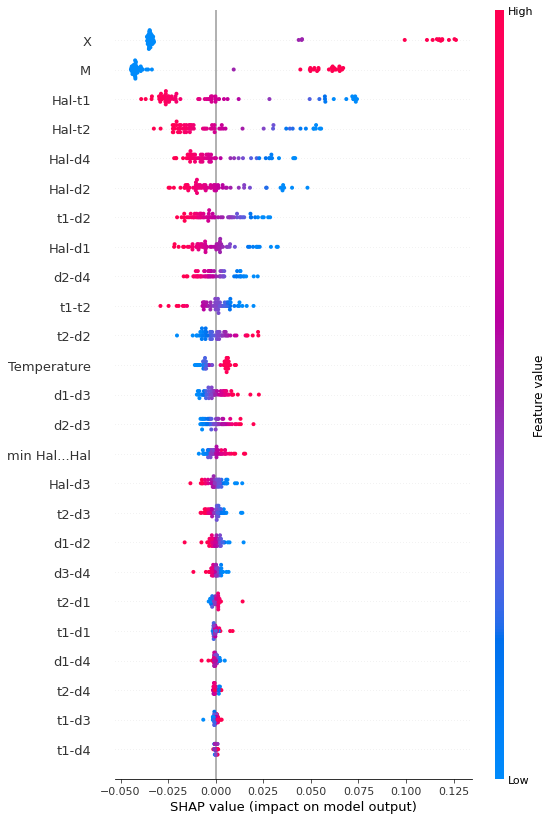

In [21]:
x_0 = x_train[descriptors_sets[0]]
regressor = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=0.75, n_restarts_optimizer=10, normalize_y=True)
regressor.fit(x_0, y_train)
explainer = shap.explainers.Permutation(regressor.predict, x_0)
shap_values = shap.explainers.Permutation(regressor.predict, x_0)
shap_values = explainer(x_0)
shap.summary_plot(shap_values, x_0, show=True, max_display=25)
#plt.savefig("shap21.png",dpi=300)

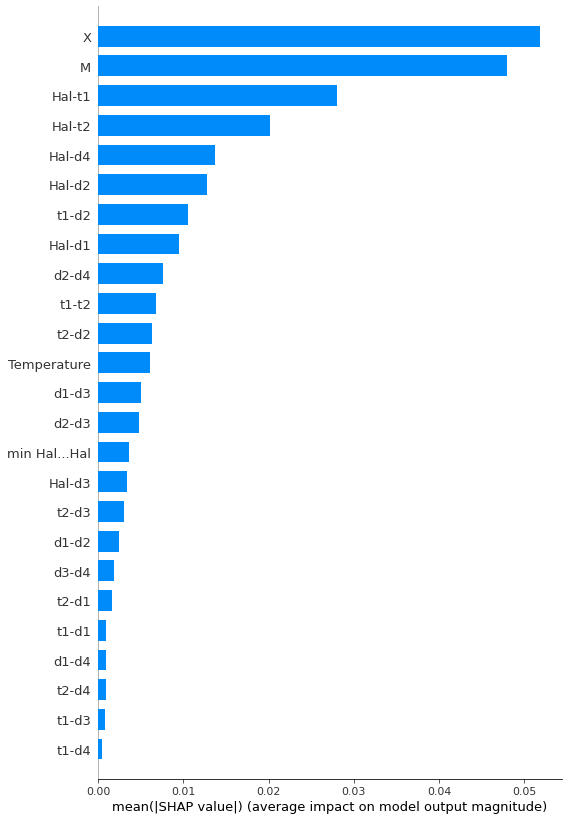

In [22]:
shap.summary_plot(shap_values, x_0, plot_type="bar", show=True, max_display=25)
#plt.savefig("shap21_2.png",dpi=300)

## 2. Обучение на 15 геометрических признаках

In [23]:
# Наилучшее пространство признаков:

In [24]:
desc_15 = ['M', 'X', 'Temperature', 'min Hal...Hal', 'Hal-t1', 'Hal-t2', 'Hal-d1', 'Hal-d2', 'Hal-d3', 'Hal-d4', 't1-t2', 't1-d2', 't2-d2', 't2-d3', 'd1-d2', 'd1-d3', 'd2-d3', 'd2-d4', 'd3-d4']

In [25]:
# Подбор гиперпараметров

# a = [0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
# gpr1 = {'GPR_rbf ' + str(x): GaussianProcessRegressor(kernel=RBF(), alpha=x, n_restarts_optimizer=10, normalize_y=True) for x in a}
#          # 'GPR_mat': GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=0.2, n_restarts_optimizer=10, normalize_y=True),
# res_gpr2 = pipline_true(x_train, x_test, y_train, y_test, desc_15, models=gpr1, metrics=metrics)
# res_gpr2[0]

In [26]:
res2 = pipline_true(x_train, x_test, y_train, y_test, desc_15, models=models1, metrics=metrics)

Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bou


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


In [27]:
# Результаты кросс-валидации
res2[0] #.to_excel('15_val.xlsx')

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.070683  0.001814  0.084556  0.002525  0.075983  0.001666   
MAE on validate   0.115800  0.122375  0.122850  0.116603  0.110174  0.100246   
MSE on train      0.009391  0.000490  0.011472  0.000681  0.008932  0.000387   
MSE on validate   0.028151  0.060184  0.028476  0.056451  0.022030  0.038707   
RMSE on train     0.096873  0.002670  0.107057  0.003347  0.094486  0.002142   
RMSE on validate  0.115800  0.122375  0.122850  0.116603  0.110174  0.100246   
R2 on train       0.872375  0.006600  0.844102  0.009109  0.878604  0.005433   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.080485  0.002295  0.067791  0.001399  0.066321  0.001424   
MAE on validate   0.125103  0.109943  0.087175  0.088141  0.087592  0.088806   
MSE on train      0.008347  0.000386  0.009404  0.000413  0.009050  0.000402   
MSE on validate   0.027549  0.050846  0.015247  0.035068  0.015436  0.035441   
RMSE on train     0.091337  0.002206  0.096946  0.002268  0.095103  0.002252   
RMSE on validate  0.125103  0.109943  0.087175  0.088141  0.087592  0.088806   
R2 on train       0.886552  0.005415  0.872204  0.005703  0.877017  0.005470   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.067791  0.001399  0.094877  0.001528  0.028991  0.001265  
MAE on validate   0.087175  0.088141  0.104598  0.104146  0.097524  0.095089  
MSE on train      0.009404  0.000413  0.017071  0.000427  0.001556  0.000122  
MSE on validate   0.015247  0.035068  0.021618  0.051402  0.018412  0.038121  
RMSE on train     0.096946  0.002268  0.130646  0.001651  0.039414  0.001705  
RMSE on validate  0.087175  0.088141  0.104598  0.104146  0.097524  0.095089  
R2 on train       0.872204  0.005703  0.767985  0.006302  0.978847  0.001718

In [28]:
# Графики

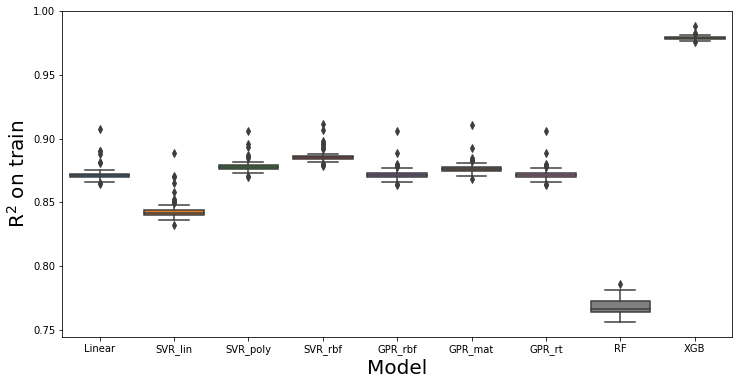

In [29]:
r2_plot(res2, save=False)

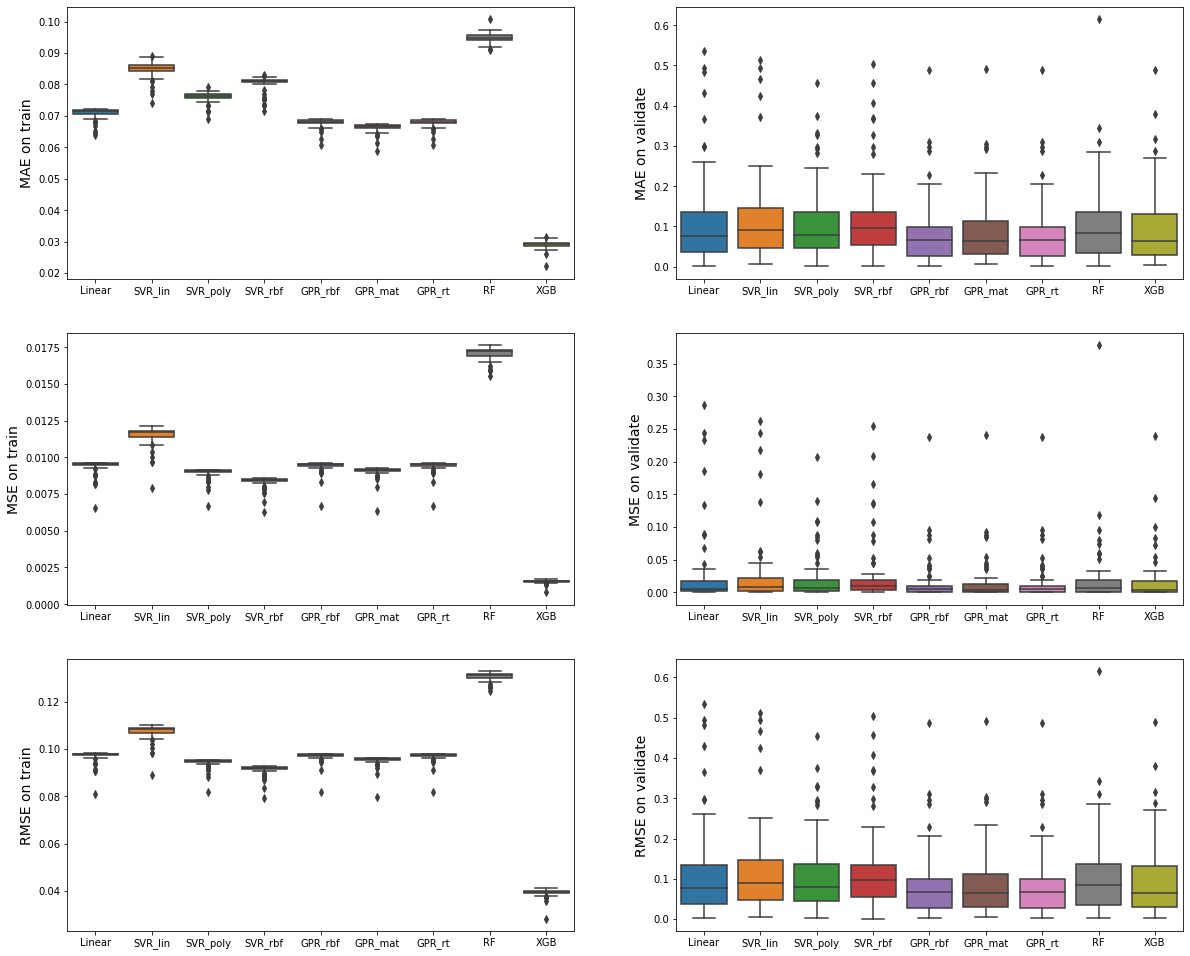

In [30]:
score_plots(res2, save=False)

In [31]:
# Объекты, на которых наибольшие ошибки
find_biggest_error(res2[2])

,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,72 0.286 79 0.244 78 0.232 82 0.185 28 0....,79 0.263 78 0.244 72 0.218 28 0.180 82 0....,79 0.207 75 0.140 52 0.109 28 0.107 78 0....,78 0.254 79 0.209 75 0.166 28 0.136 33 0....,79 0.238 78 0.096 28 0.087 52 0.082 42 0....,79 0.241 78 0.092 28 0.088 52 0.084 42 0....,79 0.238 78 0.096 28 0.087 52 0.082 42 0....,79 0.378 83 0.117 42 0.095 52 0.080 78 0....,79 0.239 28 0.143 83 0.100 42 0.082 82 0....
RMSE on validate,72 0.535 79 0.494 78 0.482 82 0.430 28 0....,79 0.512 78 0.493 72 0.467 28 0.425 82 0....,79 0.455 75 0.374 52 0.331 28 0.328 78 0....,78 0.504 79 0.457 75 0.407 28 0.368 33 0....,79 0.488 78 0.310 28 0.296 52 0.286 42 0....,79 0.491 78 0.304 28 0.296 52 0.291 42 0....,79 0.488 78 0.310 28 0.296 52 0.286 42 0....,79 0.614 83 0.343 42 0.309 52 0.284 78 0....,79 0.489 28 0.379 83 0.316 42 0.288 82 0....


In [32]:
# Предсказание на тесте
res2[1] #.to_excel('15_test.xlsx')

,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.071005,0.084683,0.076244,0.081082,0.067928,0.066469,0.067928,0.094123,0.029618
MAE on test,0.062001,0.066280,0.063042,0.075618,0.047260,0.047891,0.047260,0.098436,0.063977
MSE on all train,0.009482,0.011651,0.008991,0.008433,0.009438,0.009085,0.009438,0.017042,0.001640
MSE on test,0.006813,0.005878,0.006894,0.007296,0.004210,0.004289,0.004210,0.022751,0.009658
RMSE on all train,0.097375,0.107941,0.094821,0.091833,0.097151,0.095318,0.097151,0.130546,0.040503
RMSE on test,0.082543,0.076666,0.083030,0.085419,0.064882,0.065487,0.064882,0.150834,0.098273
R2 on all train,0.871196,0.841727,0.877866,0.885440,0.871788,0.876581,0.871788,0.768496,0.977715
R2 on test,0.903077,0.916389,0.901931,0.896206,0.940116,0.938993,0.940116,0.676361,0.862617


Оценка важности дескрипторов

GaussianProcessRegressor(alpha=0.2, kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, normalize_y=True)

Permutation explainer: 65it [00:15,  1.45it/s]                                                                         


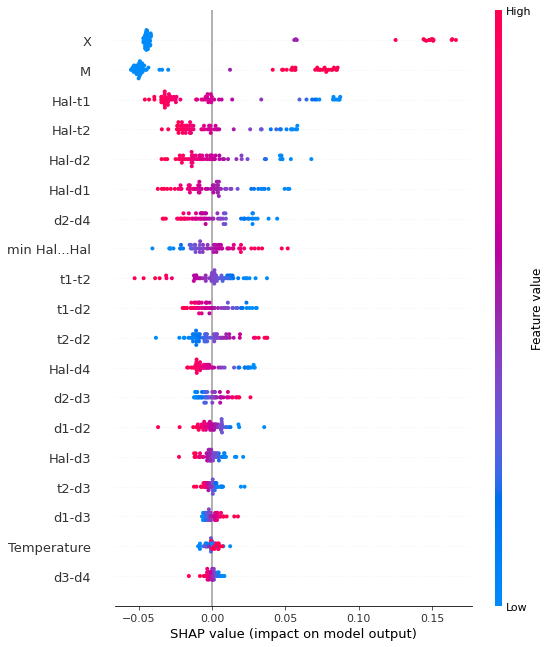

In [33]:
x_0 = x_train[desc_15]
regressor = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=0.2, n_restarts_optimizer=10, normalize_y=True)
regressor.fit(x_0, y_train)
explainer = shap.explainers.Permutation(regressor.predict, x_0)
shap_values = shap.explainers.Permutation(regressor.predict, x_0)
shap_values = explainer(x_0)
shap.summary_plot(shap_values, x_0, show=True, max_display=19)
#plt.savefig("shap15.png",dpi=300)

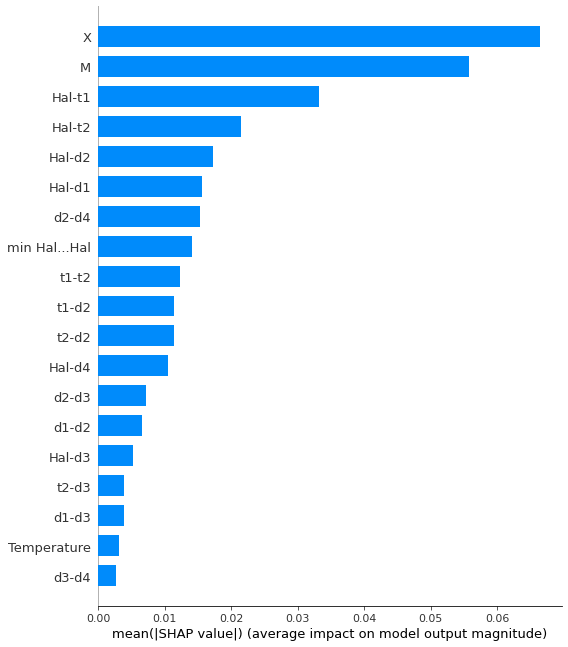

In [34]:
shap.summary_plot(shap_values, x_0, plot_type="bar", show=True, max_display=19)
#plt.savefig("shap15_2.png",dpi=300)

In [35]:
# Сохранение предобученной модели
with open('model_1_for_19d.pickle', 'wb') as f:
    pickle.dump((regressor, scaler), f)

## 3. Обучение на 2 геометрических признаках

In [36]:
# Подготовка данных
x_train, x_test, y_train, y_test, scaler = train_test_split_and_normolize(df, drop=False, train_size=0.85, random_state=159, shuffle=True, stratify=df['X'])
sum(x_train['I'] == 1), sum(x_test['I'] == 1), sum(x_train['Br'] == 1), sum(x_test['Br'] == 1), sum(x_train['Br'] == 0.5), sum(x_test['Br'] == 0.5)

In train set 67 In test set 12


(50, 9, 14, 3, 3, 0)

In [37]:
descriptors_sets3 = [['M', 'X', 'Temperature', 'min Hal...Hal', 'delta d', 'sigma^2'],
                ['M', 'X', 'Temperature', 'aver Hal...Hal', 'delta d', 'sigma^2'],
                ['M', 'X', 'Temperature', 'aver Hal...Hal', 'Number of Hal...Hal contacts', 'delta d', 'sigma^2'],
                ['M', 'X', 'Temperature', 'N/aver-d', 'delta d', 'sigma^2'],
                ['M', 'X', 'Temperature', 'min Hal...Hal', 'Number of Hal...Hal contacts', 'delta d', 'sigma^2'],
               ]

In [38]:
# Подбор гиперпараметров

# a = [0.1, 0.15, 0.19, 0.2, 0.21, 0.25, 0.5, 0.75, 1]
# gpr1 = {'GPR_rbf ' + str(x): GaussianProcessRegressor(kernel=RBF(), alpha=x, n_restarts_optimizer=10, normalize_y=True) for x in a}
#          # 'GPR_mat': GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=0.2, n_restarts_optimizer=10, normalize_y=True),
# res_gpr3 = pipline_true(x_train, x_test, y_train, y_test, descriptors_sets3[2], models=gpr1, metrics=metrics)
# res_gpr3[0]

In [39]:
res3 = []
for descriptors_set in descriptors_sets3:
    res3.append(pipline_true(x_train, x_test, y_train, y_test, descriptors_set, models=models1, metrics=metrics))

Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper 


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper 


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper 


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper 


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


Linear

SVR_lin

SVR_poly

SVR_rbf

GPR_rbf

GPR_mat

GPR_rt


The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter alpha is close to the specified upper 


RF

XGB



The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


In [40]:
# Результаты кросс-валидации
for r in res3:
    r[0]

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.081356  0.001624  0.087724  0.002161  0.089570  0.001610   
MAE on validate   0.092027  0.095720  0.097298  0.099928  0.105338  0.091551   
MSE on train      0.013809  0.000523  0.014307  0.000533  0.013224  0.000480   
MSE on validate   0.017494  0.038485  0.019303  0.043262  0.019353  0.035936   
RMSE on train     0.117490  0.002317  0.119588  0.002319  0.114975  0.002163   
RMSE on validate  0.092027  0.095720  0.097298  0.099928  0.105338  0.091551   
R2 on train       0.819528  0.006894  0.813027  0.007024  0.827160  0.006794   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.083256  0.001713  0.079598  0.001635  0.078592  0.001646   
MAE on validate   0.108954  0.102021  0.095228  0.097671  0.095775  0.097377   
MSE on train      0.011117  0.000419  0.012984  0.000486  0.012584  0.000471   
MSE on validate   0.022124  0.046272  0.018466  0.040544  0.018514  0.040369   
RMSE on train     0.105419  0.002072  0.113927  0.002216  0.112158  0.002184   
RMSE on validate  0.108954  0.102021  0.095228  0.097671  0.095775  0.097377   
R2 on train       0.854689  0.005970  0.830303  0.006528  0.835534  0.006312   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.079598  0.001635  0.109519  0.001535  0.052018  0.001476  
MAE on validate   0.095228  0.097671  0.113836  0.096586  0.087394  0.109539  
MSE on train      0.012984  0.000486  0.020436  0.000761  0.005953  0.000331  
MSE on validate   0.018466  0.040544  0.022148  0.051004  0.019457  0.055246  
RMSE on train     0.113927  0.002216  0.142926  0.002829  0.077124  0.002289  
RMSE on validate  0.095228  0.097671  0.113836  0.096586  0.087394  0.109539  
R2 on train       0.830303  0.006528  0.732929  0.010037  0.922198  0.004335

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.080342  0.001518  0.082647  0.001974  0.087641  0.001413   
MAE on validate   0.090384  0.096534  0.094148  0.102840  0.104518  0.095300   
MSE on train      0.013959  0.000529  0.014303  0.000538  0.013178  0.000461   
MSE on validate   0.017349  0.038631  0.019282  0.041085  0.019870  0.038284   
RMSE on train     0.118128  0.002331  0.119571  0.002333  0.114775  0.002080   
RMSE on validate  0.090384  0.096534  0.094148  0.102840  0.104518  0.095300   
R2 on train       0.817563  0.007012  0.813077  0.007214  0.827766  0.006529   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.078129  0.001452  0.078724  0.001578  0.077637  0.001569   
MAE on validate   0.110067  0.111880  0.094437  0.098098  0.095021  0.097481   
MSE on train      0.010518  0.000374  0.012912  0.000477  0.012426  0.000459   
MSE on validate   0.024445  0.046675  0.018398  0.040822  0.018390  0.040533   
RMSE on train     0.102540  0.001900  0.113609  0.002175  0.111453  0.002137   
RMSE on validate  0.110067  0.111880  0.094437  0.098098  0.095021  0.097481   
R2 on train       0.862525  0.005364  0.831254  0.006352  0.837599  0.006099   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.078724  0.001578  0.109675  0.001527  0.053422  0.001376  
MAE on validate   0.094437  0.098098  0.114247  0.097048  0.091795  0.105671  
MSE on train      0.012912  0.000477  0.020490  0.000757  0.006234  0.000344  
MSE on validate   0.018398  0.040822  0.022330  0.051159  0.019426  0.054063  
RMSE on train     0.113609  0.002175  0.143116  0.002806  0.078919  0.002317  
RMSE on validate  0.094437  0.098098  0.114247  0.097048  0.091795  0.105671  
R2 on train       0.831255  0.006352  0.732216  0.010088  0.918536  0.004510

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.080574  0.001573  0.083979  0.002111  0.082369  0.001568   
MAE on validate   0.093378  0.099553  0.097155  0.105099  0.106594  0.114628   
MSE on train      0.013872  0.000529  0.014317  0.000517  0.012208  0.000479   
MSE on validate   0.018482  0.040108  0.020320  0.042785  0.024306  0.054445   
RMSE on train     0.117756  0.002335  0.119631  0.002241  0.110467  0.002239   
RMSE on validate  0.093378  0.099553  0.097155  0.105099  0.106594  0.114628   
R2 on train       0.818710  0.006962  0.812890  0.007000  0.840433  0.006786   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.077367  0.001305  0.076426  0.001563  0.075401  0.001583   
MAE on validate   0.121266  0.120611  0.094221  0.101447  0.095001  0.101108   
MSE on train      0.009195  0.000257  0.012459  0.000459  0.012007  0.000441   
MSE on validate   0.029036  0.053394  0.019015  0.040674  0.019095  0.040449   
RMSE on train     0.095882  0.001365  0.111600  0.002114  0.109559  0.002066   
RMSE on validate  0.121266  0.120611  0.094221  0.101447  0.095001  0.101108   
R2 on train       0.879802  0.004197  0.837167  0.006180  0.843069  0.005921   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.076426  0.001563  0.109733  0.001470  0.054332  0.001457  
MAE on validate   0.094221  0.101447  0.114556  0.096741  0.094257  0.104218  
MSE on train      0.012459  0.000459  0.020513  0.000743  0.006189  0.000338  
MSE on validate   0.019015  0.040674  0.022342  0.051038  0.019584  0.052499  
RMSE on train     0.111600  0.002114  0.143198  0.002748  0.078640  0.002277  
RMSE on validate  0.094221  0.101447  0.114556  0.096741  0.094257  0.104218  
R2 on train       0.837167  0.006180  0.731917  0.009830  0.919113  0.004418

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.087256  0.001693  0.091107  0.001681  0.078249  0.001447   
MAE on validate   0.100849  0.105047  0.103105  0.107481  0.098157  0.107004   
MSE on train      0.015177  0.000573  0.015530  0.000535  0.011945  0.000396   
MSE on validate   0.021041  0.046548  0.022010  0.050446  0.020914  0.047636   
RMSE on train     0.123172  0.002418  0.124602  0.002222  0.109280  0.001858   
RMSE on validate  0.100849  0.105047  0.103105  0.107481  0.098157  0.107004   
R2 on train       0.801662  0.007245  0.797041  0.006794  0.843863  0.005791   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.081465  0.002011  0.079633  0.001604  0.078458  0.001629   
MAE on validate   0.114282  0.116957  0.096553  0.102170  0.096626  0.101296   
MSE on train      0.011728  0.000519  0.013134  0.000484  0.012716  0.000468   
MSE on validate   0.026535  0.052990  0.019605  0.042063  0.019444  0.041287   
RMSE on train     0.108267  0.002482  0.114581  0.002174  0.112744  0.002138   
RMSE on validate  0.114282  0.116957  0.096553  0.102170  0.096626  0.101296   
R2 on train       0.846705  0.007332  0.828352  0.006447  0.833814  0.006256   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.079622  0.001607  0.109489  0.001509  0.055273  0.001341  
MAE on validate   0.096615  0.102178  0.113989  0.096811  0.092149  0.107413  
MSE on train      0.013130  0.000484  0.020428  0.000747  0.006644  0.000385  
MSE on validate   0.019619  0.042062  0.022226  0.051183  0.019857  0.056749  
RMSE on train     0.114567  0.002176  0.142901  0.002769  0.081476  0.002508  
RMSE on validate  0.096615  0.102178  0.113989  0.096811  0.092149  0.107413  
R2 on train       0.828397  0.006453  0.733020  0.009982  0.913172  0.004916

Linear             SVR_lin            SVR_poly            \
                      mean       std      mean       std      mean       std   
MAE on train      0.081299  0.001646  0.088157  0.001994  0.082957  0.001687   
MAE on validate   0.094083  0.098713  0.098361  0.099070  0.107225  0.112662   
MSE on train      0.013803  0.000534  0.014336  0.000538  0.012104  0.000473   
MSE on validate   0.018451  0.040616  0.019343  0.041657  0.024001  0.052959   
RMSE on train     0.117462  0.002371  0.119712  0.002341  0.109998  0.002211   
RMSE on validate  0.094083  0.098713  0.098361  0.099070  0.107225  0.112662   
R2 on train       0.819611  0.007018  0.812633  0.007244  0.841787  0.006719   

                   SVR_rbf             GPR_rbf             GPR_mat            \
                      mean       std      mean       std      mean       std   
MAE on train      0.081021  0.001909  0.077334  0.001607  0.075981  0.001582   
MAE on validate   0.122533  0.114100  0.095351  0.100781  0.095652  0.100929   
MSE on train      0.009710  0.000345  0.012478  0.000461  0.012036  0.000442   
MSE on validate   0.027839  0.048959  0.019097  0.040695  0.019184  0.040448   
RMSE on train     0.098525  0.001807  0.111684  0.002123  0.109690  0.002073   
RMSE on validate  0.122533  0.114100  0.095351  0.100781  0.095652  0.100929   
R2 on train       0.873071  0.005129  0.836920  0.006203  0.842694  0.005939   

                    GPR_rt                  RF                 XGB            
                      mean       std      mean       std      mean       std  
MAE on train      0.077334  0.001607  0.109512  0.001458  0.053019  0.001636  
MAE on validate   0.095351  0.100781  0.113819  0.096388  0.090523  0.108799  
MSE on train      0.012478  0.000461  0.020434  0.000739  0.005926  0.000329  
MSE on validate   0.019097  0.040695  0.022107  0.050977  0.019855  0.055580  
RMSE on train     0.111684  0.002123  0.142922  0.002746  0.076944  0.002280  
RMSE on validate  0.095351  0.100781  0.113819  0.096388  0.090523  0.108799  
R2 on train       0.836920  0.006203  0.732947  0.009810  0.922560  0.004322

In [41]:
# Наибольшие ошибки
for r in res3:
    find_biggest_error(r[2])

,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,79 0.244 78 0.131 52 0.122 82 0.077 28 0....,79 0.241 72 0.215 78 0.113 52 0.096 82 0....,79 0.201 47 0.156 78 0.116 42 0.076 83 0....,78 0.236 79 0.235 52 0.186 82 0.064 45 0....,79 0.253 78 0.135 52 0.125 28 0.085 82 0....,79 0.252 78 0.133 52 0.123 28 0.086 82 0....,79 0.253 78 0.135 52 0.125 28 0.085 82 0....,79 0.385 83 0.109 42 0.100 23 0.100 78 0....,79 0.384 78 0.184 52 0.126 83 0.097 28 0....
RMSE on validate,79 0.494 78 0.362 52 0.350 82 0.277 28 0....,79 0.491 72 0.463 78 0.337 52 0.311 82 0....,79 0.448 47 0.395 78 0.340 42 0.276 83 0....,78 0.485 79 0.485 52 0.432 82 0.254 45 0....,79 0.503 78 0.368 52 0.353 28 0.293 82 0....,79 0.502 78 0.364 52 0.351 28 0.293 82 0....,79 0.503 78 0.368 52 0.353 28 0.293 82 0....,79 0.620 83 0.330 42 0.317 23 0.317 78 0....,79 0.619 78 0.429 52 0.355 83 0.312 28 0....


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,79 0.246 78 0.138 52 0.116 83 0.069 28 0....,79 0.238 78 0.152 72 0.135 52 0.108 83 0....,79 0.219 47 0.166 78 0.110 72 0.082 83 0....,79 0.238 78 0.192 52 0.169 47 0.145 45 0....,79 0.255 78 0.136 52 0.122 28 0.091 83 0....,79 0.254 78 0.132 52 0.120 28 0.091 83 0....,79 0.255 78 0.136 52 0.122 28 0.091 83 0....,79 0.384 83 0.110 42 0.105 23 0.103 78 0....,79 0.388 78 0.164 52 0.110 83 0.104 28 0....
RMSE on validate,79 0.496 78 0.372 52 0.341 83 0.262 28 0....,79 0.488 78 0.390 72 0.368 52 0.329 83 0....,79 0.468 47 0.407 78 0.332 72 0.286 83 0....,79 0.487 78 0.438 52 0.412 47 0.380 45 0....,79 0.504 78 0.369 52 0.349 28 0.303 83 0....,79 0.504 78 0.364 52 0.346 28 0.303 83 0....,79 0.504 78 0.369 52 0.349 28 0.303 83 0....,79 0.620 83 0.332 42 0.324 23 0.321 78 0....,79 0.623 78 0.405 52 0.332 83 0.323 28 0....


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,79 0.249 78 0.142 52 0.122 82 0.076 72 0....,79 0.234 72 0.172 78 0.152 52 0.112 83 0....,79 0.309 47 0.264 78 0.140 52 0.105 82 0....,52 0.221 79 0.216 78 0.215 47 0.198 82 0....,79 0.239 78 0.144 52 0.125 28 0.096 82 0....,79 0.237 78 0.142 52 0.123 28 0.098 82 0....,79 0.239 78 0.144 52 0.125 28 0.096 82 0....,79 0.384 83 0.109 42 0.106 23 0.101 78 0....,79 0.373 78 0.161 52 0.110 83 0.101 28 0....
RMSE on validate,79 0.499 78 0.377 52 0.350 82 0.277 72 0....,79 0.484 72 0.414 78 0.390 52 0.335 83 0....,79 0.556 47 0.514 78 0.375 52 0.325 82 0....,52 0.470 79 0.465 78 0.464 47 0.445 82 0....,79 0.488 78 0.380 52 0.353 28 0.310 82 0....,79 0.487 78 0.378 52 0.351 28 0.313 82 0....,79 0.488 78 0.380 52 0.353 28 0.310 82 0....,79 0.619 83 0.330 42 0.326 23 0.318 78 0....,79 0.611 78 0.401 52 0.332 83 0.319 28 0....


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,79 0.268 72 0.177 78 0.157 52 0.127 83 0....,79 0.320 72 0.190 78 0.134 52 0.121 83 0....,79 0.332 78 0.130 52 0.097 82 0.096 83 0....,78 0.278 79 0.235 52 0.187 47 0.133 82 0....,79 0.244 78 0.154 52 0.125 28 0.096 72 0....,79 0.239 78 0.152 52 0.124 28 0.097 72 0....,79 0.244 78 0.154 52 0.125 28 0.096 72 0....,79 0.385 83 0.111 23 0.102 42 0.100 78 0....,79 0.392 78 0.201 28 0.112 52 0.110 83 0....
RMSE on validate,79 0.518 72 0.421 78 0.397 52 0.357 83 0....,79 0.566 72 0.436 78 0.366 52 0.348 83 0....,79 0.576 78 0.361 52 0.311 82 0.311 83 0....,78 0.527 79 0.485 52 0.432 47 0.364 82 0....,79 0.494 78 0.392 52 0.354 28 0.310 72 0....,79 0.489 78 0.389 52 0.352 28 0.311 72 0....,79 0.494 78 0.392 52 0.354 28 0.310 72 0....,79 0.621 83 0.333 23 0.320 42 0.317 78 0....,79 0.626 78 0.448 28 0.336 52 0.332 83 0....


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MSE on validate,79 0.259 78 0.133 52 0.124 82 0.086 72 0....,79 0.241 72 0.185 78 0.121 52 0.096 82 0....,79 0.317 47 0.221 78 0.142 52 0.131 82 0....,79 0.218 78 0.208 52 0.178 47 0.163 82 0....,79 0.241 78 0.142 52 0.128 28 0.092 82 0....,79 0.239 78 0.140 52 0.127 28 0.094 82 0....,79 0.241 78 0.142 52 0.128 28 0.092 82 0....,79 0.385 83 0.108 23 0.101 42 0.101 78 0....,79 0.389 78 0.182 52 0.126 83 0.096 28 0....
RMSE on validate,79 0.509 78 0.366 52 0.353 82 0.293 72 0....,79 0.491 72 0.430 78 0.348 52 0.310 82 0....,79 0.563 47 0.471 78 0.378 52 0.362 82 0....,79 0.467 78 0.456 52 0.422 47 0.404 82 0....,79 0.491 78 0.377 52 0.358 28 0.304 82 0....,79 0.488 78 0.375 52 0.356 28 0.307 82 0....,79 0.491 78 0.377 52 0.358 28 0.304 82 0....,79 0.620 83 0.328 23 0.318 42 0.317 78 0....,79 0.623 78 0.427 52 0.355 83 0.311 28 0....


In [42]:
# Предсказание
for r in res3:
    r[1]

,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.081376,0.087998,0.089764,0.083532,0.079635,0.078651,0.079635,0.109714,0.052536
MAE on test,0.064542,0.063229,0.064166,0.079572,0.058847,0.059092,0.058847,0.090627,0.056140
MSE on all train,0.013833,0.014338,0.013274,0.011153,0.013015,0.012618,0.013015,0.020480,0.006033
MSE on test,0.005286,0.005253,0.006379,0.008089,0.004713,0.004851,0.004713,0.011616,0.005619
RMSE on all train,0.117612,0.119741,0.115213,0.105610,0.114085,0.112328,0.114085,0.143109,0.077674
RMSE on test,0.072706,0.072475,0.079866,0.089940,0.068649,0.069650,0.068649,0.107777,0.074961
R2 on all train,0.819295,0.812694,0.826593,0.854296,0.829971,0.835169,0.829971,0.732452,0.921184
R2 on test,0.902510,0.903129,0.882362,0.850815,0.913085,0.910532,0.913085,0.785773,0.896367


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.080357,0.082782,0.087561,0.077922,0.078769,0.077688,0.078769,0.109646,0.053024
MAE on test,0.059789,0.062768,0.060555,0.092887,0.058233,0.058615,0.058233,0.090115,0.060039
MSE on all train,0.013982,0.014295,0.013193,0.010522,0.012942,0.012459,0.012942,0.020472,0.006296
MSE on test,0.005442,0.005702,0.005517,0.012949,0.005064,0.005205,0.005064,0.011506,0.005972
RMSE on all train,0.118244,0.119562,0.114859,0.102576,0.113762,0.111619,0.113762,0.143079,0.079350
RMSE on test,0.073769,0.075514,0.074280,0.113793,0.071164,0.072148,0.071164,0.107267,0.077277
R2 on all train,0.817349,0.813254,0.827656,0.862546,0.830931,0.837242,0.830931,0.732564,0.917746
R2 on test,0.899637,0.894834,0.898244,0.761190,0.906601,0.903999,0.906601,0.787796,0.889867


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.080644,0.084150,0.082251,0.077086,0.076485,0.075495,0.076485,0.109885,0.053904
MAE on test,0.059075,0.059857,0.078481,0.075371,0.057636,0.056316,0.057636,0.090418,0.063517
MSE on all train,0.013900,0.014321,0.012242,0.009166,0.012500,0.012053,0.012500,0.020528,0.006238
MSE on test,0.004824,0.004722,0.008990,0.007237,0.004349,0.004283,0.004349,0.011546,0.006829
RMSE on all train,0.117899,0.119671,0.110643,0.095739,0.111805,0.109784,0.111805,0.143275,0.078982
RMSE on test,0.069454,0.068720,0.094817,0.085073,0.065949,0.065446,0.065949,0.107452,0.082638
R2 on all train,0.818414,0.812913,0.840077,0.880259,0.836700,0.842549,0.836700,0.731833,0.918506
R2 on test,0.911034,0.912907,0.834197,0.866523,0.919789,0.921008,0.919789,0.787064,0.874054


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.087318,0.090961,0.078103,0.081611,0.079652,0.078519,0.079652,0.109881,0.055676
MAE on test,0.069203,0.069171,0.073238,0.085939,0.058779,0.058190,0.058779,0.091116,0.068250
MSE on all train,0.015209,0.015530,0.011947,0.011773,0.013172,0.012756,0.013172,0.020528,0.006678
MSE on test,0.006352,0.006190,0.007473,0.009758,0.004923,0.004801,0.004923,0.011721,0.008002
RMSE on all train,0.123326,0.124621,0.109301,0.108502,0.114770,0.112944,0.114770,0.143275,0.081720
RMSE on test,0.079701,0.078675,0.086445,0.098780,0.070164,0.069288,0.070164,0.108263,0.089456
R2 on all train,0.801311,0.797116,0.843933,0.846204,0.827922,0.833353,0.827922,0.731832,0.912758
R2 on test,0.882847,0.885846,0.862183,0.820045,0.909207,0.911461,0.909207,0.783837,0.852414


,Linear,SVR_lin,SVR_poly,SVR_rbf,GPR_rbf,GPR_mat,GPR_rt,RF,XGB
MAE on all train,0.081308,0.088245,0.083051,0.081280,0.077417,0.076060,0.077417,0.109452,0.053093
MAE on test,0.064493,0.062952,0.078799,0.076769,0.060357,0.059374,0.060357,0.090240,0.058855
MSE on all train,0.013831,0.014355,0.012149,0.009750,0.012521,0.012083,0.012521,0.020430,0.006012
MSE on test,0.005228,0.005184,0.008916,0.007919,0.004592,0.004529,0.004592,0.011592,0.006036
RMSE on all train,0.117607,0.119810,0.110224,0.098744,0.111896,0.109921,0.111896,0.142932,0.077538
RMSE on test,0.072303,0.071998,0.094424,0.088989,0.067766,0.067294,0.067766,0.107665,0.077690
R2 on all train,0.819310,0.812477,0.841285,0.872624,0.836432,0.842157,0.836432,0.733113,0.921459
R2 on test,0.903586,0.904400,0.835567,0.853951,0.915308,0.916482,0.915308,0.786217,0.888684


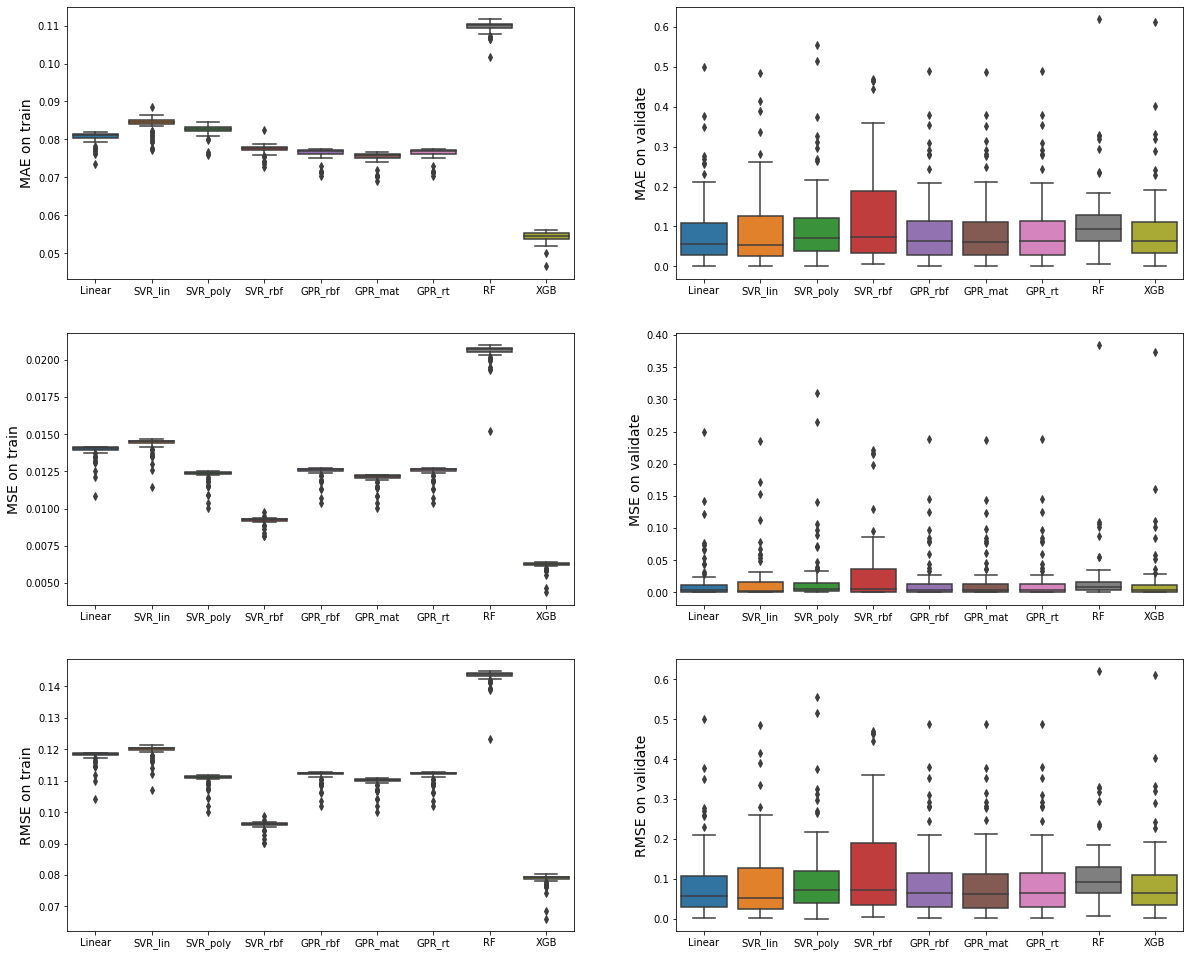

In [43]:
score_plots(res3[2], save=False)

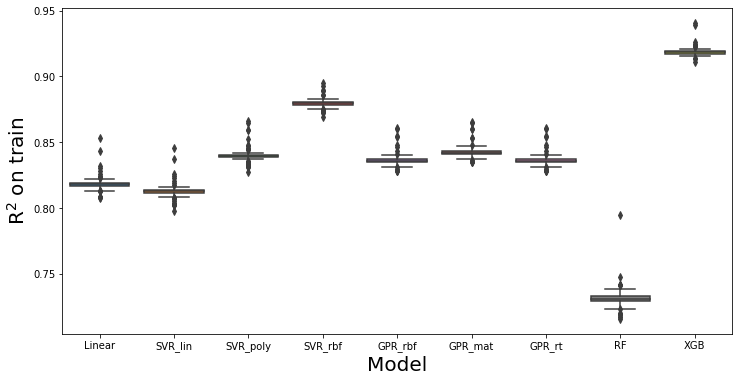

In [44]:
r2_plot(res3[2], save=False)

Оценка важности признаков

GaussianProcessRegressor(alpha=0.2, kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, normalize_y=True)

Permutation explainer: 68it [00:15,  1.43it/s]                                                                         


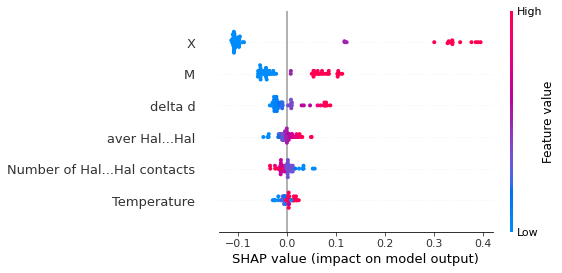

In [45]:
x_0 = x_train[descriptors_sets3[2]]
regressor2 = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=0.2, n_restarts_optimizer=10, normalize_y=True)
regressor2.fit(x_0, y_train)
explainer = shap.explainers.Permutation(regressor2.predict, x_0)
shap_values = shap.explainers.Permutation(regressor2.predict, x_0)
shap_values = explainer(x_0)
shap.summary_plot(shap_values, x_0, show=True, max_display=6)
#plt.savefig("shap2.png",dpi=300)

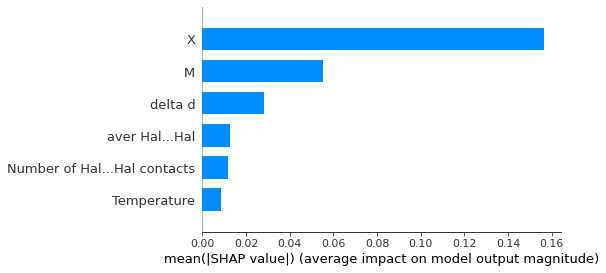

In [46]:
shap.summary_plot(shap_values, x_0, plot_type="bar", show=True, max_display=6)
#plt.savefig("shap2_gpr2.png",dpi=300)

In [47]:
# Сохранение предобученной модели
with open('model_2_for_7d.pickle', 'wb') as f:
    pickle.dump((regressor2, scaler), f)